In [43]:
import time
import requests
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cartopy.crs as ccrs
import cartopy
import zarr
import s3fs
import json
from IPython.display import HTML
from json import dumps, loads
from os.path import isfile, basename, abspath

In [2]:
cmr = "cmr.earthdata.nasa.gov"
urs = "urs.earthdata.nasa.gov"
harmony = "harmony.earthdata.nasa.gov"

cmr, urs, harmony

('cmr.earthdata.nasa.gov',
 'urs.earthdata.nasa.gov',
 'harmony.earthdata.nasa.gov')

### NASA Earthdata Login Setup

An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.

The setup_earthdata_login_auth function will allow Python scripts to log into any Earthdata Login application programmatically. To avoid being prompted for credentials every time you run and also allow clients such as curl to log in, you can add the following to a .netrc (_netrc on Windows) file in your home directory:

```shell 
    machine urs.earthdata.nasa.gov
    login <your username>
    password <your password>
```

Make sure that this file is only readable by the current user or you will receive an error stating "netrc access too permissive."

```shell
$ chmod 0600 ~/.netrc
```

*You will be prompted for your username and password if you dont have a netrc file. Note: these imports are all in the Python 3.6+ standard library.*


In [3]:
from platform import system
from netrc import netrc
from getpass import getpass
from urllib import request
from http.cookiejar import CookieJar
from os.path import join, expanduser

TOKEN_DATA = ("<token>"
              "<username>%s</username>"
              "<password>%s</password>"
              "<client_id>PODAAC CMR Client</client_id>"
              "<user_ip_address>%s</user_ip_address>"
              "</token>")


def setup_earthdata_login_auth(urs: str='urs.earthdata.nasa.gov', cmr: str='cmr.earthdata.nasa.gov'):

    # GET URS LOGIN INFO FROM NETRC OR USER PROMPTS:
    netrc_name = "_netrc" if system()=="Windows" else ".netrc"
    try:
        username, _, password = netrc(file=join(expanduser('~'), netrc_name)).authenticators(urs)
        print("# Your URS credentials were securely retrieved from your .netrc file.")
    except (FileNotFoundError, TypeError):
        print('# Please provide your Earthdata Login credentials for access.')
        print('# Your info will only be passed to %s and will not be exposed in Jupyter.' % (urs))
        username = input('Username: ')
        password = getpass('Password: ')

    # SET UP URS AUTHENTICATION FOR HTTP DOWNLOADS:
    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, urs, username, password)
    auth = request.HTTPBasicAuthHandler(manager)
    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)

    # GET TOKEN TO ACCESS RESTRICTED CMR METADATA:
    ip = requests.get("https://ipinfo.io/ip").text.strip()
    r = requests.post(
        url="https://%s/legacy-services/rest/tokens" % cmr,
        data=TOKEN_DATA % (str(username), str(password), ip),
        headers={'Content-Type': 'application/xml', 'Accept': 'application/json'}
    )
    return r.json()['token']['id']


# Provide URS credentials for HTTP download auth & CMR token retrieval:
_token = setup_earthdata_login_auth(urs=urs, cmr=cmr)

# Please provide your Earthdata Login credentials for access.
# Your info will only be passed to urs.earthdata.nasa.gov and will not be exposed in Jupyter.
Username: celiaoued
Password: ········


### GRACE LWE Thickness

In [103]:
grace_ShortName = "TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2"
r = requests.get(url=f"https://{cmr}/search/collections.umm_json",
                params = 
                 {
                     'provider': "POCLOUD",
                     'token': _token,
                     'concept-id': "C1938032626-POCLOUD"
                     #'ShortName': grace_ShortName,
                 }
                
                )
grace_coll = r.json()
grace_coll['hits']

1

In [5]:
grace_coll_meta = grace_coll['items'][0]['meta']
grace_coll_meta

{'revision-id': 3,
 'deleted': False,
 'format': 'application/vnd.nasa.cmr.umm+json',
 'provider-id': 'POCLOUD',
 'user-id': 'chen5510',
 'has-formats': False,
 'has-spatial-subsetting': False,
 'native-id': 'JPL+GRACE+and+GRACE-FO+Mascon+Ocean,+Ice,+and+Hydrology+Equivalent+Water+Height+Coastal+Resolution+Improvement+(CRI)+Filtered+Release+06+Version+02',
 'has-transforms': False,
 'has-variables': False,
 'concept-id': 'C1938032626-POCLOUD',
 'revision-date': '2021-04-19T17:26:51.036Z',
 'granule-count': 0,
 'has-temporal-subsetting': False,
 'concept-type': 'collection'}

In [6]:
r = requests.get(url=f"https://{cmr}/search/granules.umm_json", 
                 params={'provider': "POCLOUD", 
                         'ShortName': grace_ShortName, 
                         'token': _token})

grace_gran = r.json()
grace_gran['hits']

7

#### Now that there are multiple GRACE granules, take the latest monthly granule (automate finding of most recent month?)

In [7]:
grace_gran['items'][6]['meta']

{'concept-type': 'granule',
 'concept-id': 'G2029981198-POCLOUD',
 'revision-id': 1,
 'native-id': 'GRCTellus.JPL.200204_202102.GLO.RL06M.MSCNv02',
 'provider-id': 'POCLOUD',
 'format': 'application/vnd.nasa.cmr.umm+json',
 'revision-date': '2021-04-05T16:54:49.443Z'}

In [8]:
grace_gran['items'][6]['umm']['RelatedUrls']

[{'URL': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2/GRCTellus.JPL.200204_202102.GLO.RL06M.MSCNv02.nc.md5',
  'Type': 'EXTENDED METADATA',
  'Description': 'File to download'},
 {'URL': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2/GRCTellus.JPL.200204_202102.GLO.RL06M.MSCNv02.nc',
  'Type': 'GET DATA',
  'Description': 'File to download'},
 {'URL': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2/GRCTellus.JPL.200204_202102.GLO.RL06M.MSCNv02.cmr.json',
  'Type': 'EXTENDED METADATA',
  'Description': 'File to download'}]

In [9]:
grace_url = grace_gran['items'][6]['umm']['RelatedUrls'][1]['URL']
grace_url

'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2/GRCTellus.JPL.200204_202102.GLO.RL06M.MSCNv02.nc'

In [ ]:
r = requests.get(grace_url)
with open('iosos_demo_GRACEFO.nc', 'wb') as f:
    f.write(r.content)

!ncdump -h iosos_demo_GRACEFO.nc

In [104]:
ds_GRACE = xr.open_dataset('iosos_demo_GRACEFO.nc')
ds_GRACE

<xarray.Dataset>
Dimensions:        (bounds: 2, lat: 360, lon: 720, time: 194)
Coordinates:
  * lon            (lon) float64 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat            (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2002-04-17T12:00:00 ... 2021-02-15
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (time, lat, lon) float64 ...
    uncertainty    (time, lat, lon) float64 ...
    lat_bounds     (lat, bounds) float64 ...
    lon_bounds     (lon, bounds) float64 ...
    time_bounds    (time, bounds) datetime64[ns] ...
Attributes: (12/51)
    Conventions:                CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:       Unidata Dataset Discovery v1.0
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    title:                      JPL GRACE and GRACE-FO MASCON RL06Mv2
    summary:                    Monthly gravity solutions from GRACE and GRAC...
    keywords:                   Solid Earth, Geodetics/Gravity, Gravity, liqu...
    ...                         ...
    C_20_substitution:          TN-14; Loomis et al., 2019, Geophys. Res. Let...
    C_30_substitution:          TN-14; Loomis et al., 2019, Geophys. Res. Let...
    user_note_1:                The accelerometer on the GRACE-B spacecraft w...
    user_note_2:                The accelerometer on the GRACE-D spacecraft b...
    journal_reference:          Watkins, M. M., D. N. Wiese, D.-N. Yuan, C. B...
    date_created:               2021-03-30T09:03:11Z

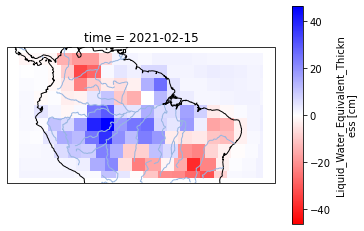

In [105]:
lat_bnds, lon_bnds = [-18, 10], [275, 330] #degrees east for longitude
ds_GRACE_subset = ds_GRACE.sel(lat=slice(*lat_bnds), lon=slice(*lon_bnds))
ds_GRACE_subset

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.RIVERS)
ds_GRACE_subset.lwe_thickness[193,:,:].plot(cmap = 'bwr_r') #106: July 2011
plt.show()

### On-premise data via OPeNDAP: River heights

In [97]:
ds_MEaSUREs = xr.open_dataset('https://opendap.jpl.nasa.gov/opendap/allData/preswot_hydrology/L2/rivers/daily/South_America_Amazon1kmdaily.nc')
ds_MEaSUREs

<xarray.Dataset>
Dimensions:   (X: 3311, Y: 3311, charlength: 26, distance: 3311, time: 9469)
Coordinates:
  * time      (time) datetime64[ns] 1993-04-08T15:20:40.665117184 ... 2019-04...
Dimensions without coordinates: X, Y, charlength, distance
Data variables:
    lon       (X) float64 ...
    lat       (Y) float64 ...
    FD        (distance) float64 ...
    height    (distance, time) float64 ...
    sat       (charlength) |S64 ...
    storage   (distance, time) float64 ...
    LakeFlag  (distance) float64 ...
    IceFlag   (time) float64 ...
Attributes: (12/40)
    title:                         GRRATS (Global River Radar Altimetry Time ...
    Conventions:                   CF-1.6, ACDD-1.3
    institution:                   Ohio State University, School of Earth Sci...
    source:                        MEaSUREs OSU Storage toolbox 2018
    keywords:                      EARTH SCIENCE,TERRESTRIAL HYDROSPHERE,SURF...
    keywords_vocabulary:           Global Change Master Directory (GCMD)
    ...                            ...
    geospatial_lat_max:            -0.6550700975069503
    geospatial_lat_units:          degree_north
    geospatial_vertical_max:       92.7681246287056
    geospatial_vertical_min:       -3.563409518163376
    geospatial_vertical_units:     m
    geospatial_vertical_positive:  up

### SMAP
#### https://podaac.jpl.nasa.gov/dataset/SMAP_JPL_L3_SSS_CAP_MONTHLY_V5

In [98]:
#initialize SMAP file list
# file_list_SMAP = []
# with open('smap_links.txt','r') as f_SMAP:
#     line_count = 0
#     opendap_count = 0
#     while True:
#         line = f_SMAP.readline()
#         if not line:
#             break
#         if (line_count % 2 != 0):
#             file_list_SMAP.append("".join([line.strip().replace('%20',' '),'.nc']))
#             opendap_count = opendap_count + 1
#         line_count = line_count + 1

file_list_SMAP = []
#create an array of the months of the year and an array for the years
counter_month = np.arange(1,13)
counter_year = np.arange(2015, 2020)

#make list of file paths
for j in counter_year:
    for i in counter_month:
        if j == 2015: #data starts in april for 2015
            if i > 3:
                if i < 10:        #for single digit months, only one number needs to be changed
                    file_list_SMAP.append('https://podaac-opendap.jpl.nasa.gov/opendap/allData/smap/L3/JPL/V5.0/monthly/%d/SMAP_L3_SSS_%d0%d_MONTHLY_V5.0.nc' % (j, j, i))
                else:             #for double digit months, 2 numbers in the string need to change
                    file_list_SMAP.append('https://podaac-opendap.jpl.nasa.gov/opendap/allData/smap/L3/JPL/V5.0/monthly/%d/SMAP_L3_SSS_%d%d_MONTHLY_V5.0.nc' % (j, j, i))
        else:
            if i < 10:        #for single digit months, only one number needs to be changed
                file_list_SMAP.append('https://podaac-opendap.jpl.nasa.gov/opendap/allData/smap/L3/JPL/V5.0/monthly/%d/SMAP_L3_SSS_%d0%d_MONTHLY_V5.0.nc' % (j, j, i))
            else:             #for double digit months, 2 numbers in the string need to change
                file_list_SMAP.append('https://podaac-opendap.jpl.nasa.gov/opendap/allData/smap/L3/JPL/V5.0/monthly/%d/SMAP_L3_SSS_%d%d_MONTHLY_V5.0.nc' % (j, j, i))

# #initialize Aquarius file list
# file_list_Aq = []
# #create an array of the months of the year and an array for the years
# counter_month = np.arange(0,12)
# counter_year = np.arange(2011, 2016)

# #make list of file paths
# for j in counter_year:
#     for i in counter_month:
#         if j == 2012: #leap-year
#             d1 = ['001', '032', '061', '092', '122', '153', '183', '214', '245', '275', '306', '336']
#             d2 = ['031', '060', '091', '121', '152', '182', '213', '244', '274', '305', '335', '366']
#         else: #all other years
#             d1 = ['001', '032', '060', '091', '121', '152', '182', '213', '244', '274', '305', '335']
#             d2 = ['031', '059', '090', '120', '151', '181', '212', '243', '273', '304', '334', '365']
        
#         if j == 2011: #data starts in the 8th month (index 7)
#             if i > 6:
#                 file_list_Aq.append('https://podaac-opendap.jpl.nasa.gov/opendap/allData/aquarius/L3/mapped/V5/monthly/SCI/%d/Q%d%s%d%s.L3m_MO_SCI_V5.0_SSS_1deg.bz2' % (j, j, d1[i], j, d2[i]))
#         elif j == 2015: #data ends in the 6th month (index 5)
#             if i < 6:
#                 file_list_Aq.append('https://podaac-opendap.jpl.nasa.gov/opendap/allData/aquarius/L3/mapped/V5/monthly/SCI/%d/Q%d%s%d%s.L3m_MO_SCI_V5.0_SSS_1deg.bz2' % (j, j, d1[i], j, d2[i]))
#         else:
#             file_list_Aq.append('https://podaac-opendap.jpl.nasa.gov/opendap/allData/aquarius/L3/mapped/V5/monthly/SCI/%d/Q%d%s%d%s.L3m_MO_SCI_V5.0_SSS_1deg.bz2' % (j, j, d1[i], j, d2[i]))

# I think though MODIS L2 is in the cloud, L3 is not.            
#initialize MODIS file list for sea surface temperature
file_list_MODIS = []
#create an array of the months of the year and an array for the years
counter_month = np.arange(0,12)
counter_year = np.arange(2011, 2020)

#make list of file paths
for j in counter_year:
    for i in counter_month:
        if j == 2012 or j == 2016: #leap-year
            d1 = ['0101', '0201', '0301', '0401', '0501', '0601', '0701', '0801', '0901', '1001', '1101', '1201']
            d2 = ['0131', '0229', '0331', '0430', '0531', '0630', '0731', '0831', '0930', '1031', '1130', '1231']
        else: #all other years
            d1 = ['0101', '0201', '0301', '0401', '0501', '0601', '0701', '0801', '0901', '1001', '1101', '1201']
            d2 = ['0131', '0228', '0331', '0430', '0531', '0630', '0731', '0831', '0930', '1031', '1130', '1231']
        
        if j == 2011: #data starts in the 8th month (index 7)
            if i > 6:
                file_list_MODIS.append('https://podaac-opendap.jpl.nasa.gov/opendap/allData/modis/L3/aqua/4um/v2019.0/9km/monthly/%d/AQUA_MODIS.%d%s_%d%s.L3m.MO.SST4.sst4.9km.nc' % (j, j, d1[i], j, d2[i]))
        elif j == 2019: #data ends in the 11th month (index 10)
            if i < 11:
                file_list_MODIS.append('https://podaac-opendap.jpl.nasa.gov/opendap/allData/modis/L3/aqua/4um/v2019.0/9km/monthly/%d/AQUA_MODIS.%d%s_%d%s.L3m.MO.SST4.sst4.9km.nc' % (j, j, d1[i], j, d2[i]))
        else:
            file_list_MODIS.append('https://podaac-opendap.jpl.nasa.gov/opendap/allData/modis/L3/aqua/4um/v2019.0/9km/monthly/%d/AQUA_MODIS.%d%s_%d%s.L3m.MO.SST4.sst4.9km.nc' % (j, j, d1[i], j, d2[i]))

            
# #initialize MODIS file list for chlorophyll
# file_list_MODIS_chl = []
# #create an array of the months of the year and an array for the years
# counter_month = np.arange(0,12)
# counter_year = np.arange(2011, 2020)

# #make list of file paths
# for j in counter_year:
#     for i in counter_month:
#         if j == 2012 or j == 2016: #leap-year
#             d1 = ['001', '032', '061', '092', '122', '153', '183', '214', '245', '275', '306', '336']
#             d2 = ['031', '060', '091', '121', '152', '182', '213', '244', '274', '305', '335', '366']
#         else: #all other years
#             d1 = ['001', '032', '060', '091', '121', '152', '182', '213', '244', '274', '305', '335']
#             d2 = ['031', '059', '090', '120', '151', '181', '212', '243', '273', '304', '334', '365']
        
#         if j == 2011: #data starts in the 8th month (index 7)
#             if i > 6:
#                 file_list_MODIS_chl.append('https://opendap.jpl.nasa.gov/opendap/hyrax/allData/modis/L3/aqua/chlA/v2014.0/4km/monthly/%d/A%d%s%d%s.L3m_MO_CHL_chlor_a_4km.nc' % (j, j, d1[i], j, d2[i]))
#         elif j == 2019: #data ends in the 10th month (index 9)
#             if i < 10:
#                 file_list_MODIS_chl.append('https://opendap.jpl.nasa.gov/opendap/hyrax/allData/modis/L3/aqua/chlA/v2014.0/4km/monthly/%d/A%d%s%d%s.L3m_MO_CHL_chlor_a_4km.nc' % (j, j, d1[i], j, d2[i]))

#         else:
#             file_list_MODIS_chl.append('https://opendap.jpl.nasa.gov/opendap/hyrax/allData/modis/L3/aqua/chlA/v2014.0/4km/monthly/%d/A%d%s%d%s.L3m_MO_CHL_chlor_a_4km.nc' % (j, j, d1[i], j, d2[i]))

            
            
#Un comment to see links lists
file_list_SMAP
#file_list_Aq
#file_list_MODIS
#file_list_MODIS_chl

['https://podaac-opendap.jpl.nasa.gov/opendap/allData/smap/L3/JPL/V5.0/monthly/2015/SMAP_L3_SSS_201504_MONTHLY_V5.0.nc',
 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/smap/L3/JPL/V5.0/monthly/2015/SMAP_L3_SSS_201505_MONTHLY_V5.0.nc',
 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/smap/L3/JPL/V5.0/monthly/2015/SMAP_L3_SSS_201506_MONTHLY_V5.0.nc',
 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/smap/L3/JPL/V5.0/monthly/2015/SMAP_L3_SSS_201507_MONTHLY_V5.0.nc',
 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/smap/L3/JPL/V5.0/monthly/2015/SMAP_L3_SSS_201508_MONTHLY_V5.0.nc',
 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/smap/L3/JPL/V5.0/monthly/2015/SMAP_L3_SSS_201509_MONTHLY_V5.0.nc',
 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/smap/L3/JPL/V5.0/monthly/2015/SMAP_L3_SSS_201510_MONTHLY_V5.0.nc',
 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/smap/L3/JPL/V5.0/monthly/2015/SMAP_L3_SSS_201511_MONTHLY_V5.0.nc',
 'https://podaac-opendap.jpl.nas

In [6]:
# username = 'blah'
# password = 'blah'
# from pydap.client import open_url
# from pydap.cas.urs import setup_session
# dataset_url = 'https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/RSS SMAP Level 3 Sea Surface Salinity Standard Mapped Image 8-Day Running Mean V4.0 Validated Dataset/'
# session = setup_session(username, password, check_url=dataset_url)
# dataset = open_url(dataset_url, session=session)

FeatureNotFound: Couldn't find a tree builder with the features you requested: lxml. Do you need to install a parser library?

In [99]:
#for OPeNDAP, we need to set the number of files that can be open at once to 10, 
#so that xa.open_mfdataset() actually reads all links (see https://github.com/pydata/xarray/issues/4082)
xr.set_options(file_cache_maxsize=10)

#to use xa.open_mfdataset which combines netCDF files
ds_SMAP = xr.open_mfdataset(file_list_SMAP, combine='by_coords')
ds_SMAP

<xarray.Dataset>
Dimensions:               (latitude: 720, longitude: 1440, time: 57)
Coordinates:
  * latitude              (latitude) float32 89.88 89.62 89.38 ... -89.62 -89.88
  * longitude             (longitude) float32 -179.9 -179.6 ... 179.6 179.9
  * time                  (time) datetime64[ns] 2015-04-16 ... 2019-12-16T12:...
Data variables:
    smap_sss              (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    anc_sss               (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    anc_sst               (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    smap_spd              (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    smap_high_spd         (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    weight                (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    land_fraction         (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ice_fraction          (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    smap_sss_uncertainty  (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/38)
    title:                       SMAP 0.25x0.25 deg grid averaged monthly SSS...
    institution:                 Jet Propulsion Laboratory
    source:                      SMAP L2B SSS
    history:                     DATA_SOURCE_VERSION V5.0 L2B SMAP SSS/WSPD
    comment:                     Gaussian-weighted map gridding of SMAP L2B S...
    Gaussian_window_radius:      45.0
    ...                          ...
    creator_name:                JPL
    creator_email:               fore@jpl.nasa.gov
    publisher_name:              Alexander G. Fore
    publisher_email:             fore@jpl.nasa.gov
    contributor_name:            Alexander Fore, Simon Yueh, Wenqing Tang, Ak...
    references:                  10.1109/TGRS.2016.2601486, 10.1109/TGRS.2016...

In [18]:
# #open and combine Aquarius files into 1 .nc file
# xr.set_options(file_cache_maxsize=10)
# #to use xa.open_mfdataset which combines netCDF files
# ds_Aq = xr.open_mfdataset(file_list_Aq, combine='nested', concat_dim='time')
# ds_Aq

<xarray.Dataset>
Dimensions:      (SSS_0: 180, SSS_1: 360, SSS_ran_unc_0: 180, SSS_ran_unc_1: 360, SSS_sys_unc_0: 180, SSS_sys_unc_1: 360, palette_0: 3, palette_1: 256, time: 47)
Dimensions without coordinates: SSS_0, SSS_1, SSS_ran_unc_0, SSS_ran_unc_1, SSS_sys_unc_0, SSS_sys_unc_1, palette_0, palette_1, time
Data variables:
    SSS          (time, SSS_0, SSS_1) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    SSS_ran_unc  (time, SSS_ran_unc_0, SSS_ran_unc_1) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    SSS_sys_unc  (time, SSS_sys_unc_0, SSS_sys_unc_1) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    palette      (time, palette_0, palette_1) int8 dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/68)
    product_name:                      Q20112132011243.L3m_MO_SCI_V5.0_SSS_1deg
    instrument:                        Aquarius
    title:                             Aquarius Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          SAC-D Aquarius
    temporal_range:                    MO
    ...                                ...
    identifier_product_doi:            http://dx.doi.org
    keywords:                          SURFACE SALINITY, SALINITY, AQUARIUS, ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    software_name:                     smigen
    software_version:                  5.20
    source:                            Q20112132011243.L3b_MO_SCI_V5.0.main

In [19]:
# #for OPeNDAP, we need to set the number of files that can be open at once to 10, 
# #so that xr.open_mfdataset() actually reads all links (see https://github.com/pydata/xarray/issues/4082)
# xr.set_options(file_cache_maxsize=10)

# #to use xr.open_mfdataset which combines netCDF files
# ds_MODIS = xr.open_mfdataset(file_list_MODIS, combine='nested', concat_dim='time')
# ds_MODIS

<xarray.Dataset>
Dimensions:    (eightbitcolor: 256, lat: 2160, lon: 4320, rgb: 3, time: 100)
Coordinates:
  * lat        (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
  * lon        (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
Dimensions without coordinates: eightbitcolor, rgb, time
Data variables:
    palette    (time, rgb, eightbitcolor) int8 dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
    sst4       (time, lat, lon) float32 dask.array<chunksize=(1, 2160, 4320), meta=np.ndarray>
    qual_sst4  (time, lat, lon) float32 dask.array<chunksize=(1, 2160, 4320), meta=np.ndarray>
Attributes: (12/59)
    product_name:                     AQUA_MODIS.20110801_20110831.L3m.MO.SST...
    instrument:                       MODIS
    title:                            MODISA Level-3 Standard Mapped Image
    project:                          Ocean Biology Processing Group (NASA/GS...
    platform:                         Aqua
    temporal_range:                   month
    ...                               ...
    publisher_url:                    https://oceandata.sci.gsfc.nasa.gov
    processing_level:                 L3 Mapped
    cdm_data_type:                    grid
    data_bins:                        Attribute edlided: Unsupported attribut...
    data_minimum:                     -1.665
    data_maximum:                     35.065

In [5]:
modis_results = requests.get(
    url='https://cmr.earthdata.nasa.gov/search/collections.umm_json', 
    params={'provider': "POCLOUD",
            'ShortName': "MODIS_A-JPL-L2P-v2019.0",
            'token': _token}
).json()

# Select the first/only record in the JSON response:
modis_coll = modis_results['items'][0]

# Select the 'concept-id' from the 'meta' dictionary:
modis_ccid = modis_coll['meta']['concept-id']

harmony_url = "https://harmony.earthdata.nasa.gov"
harmony_url_modis = f"{harmony_url}/{modis_ccid}/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?"

print(harmony_url_modis)


https://harmony.earthdata.nasa.gov/C1940473819-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?


In [8]:
(aoi_minlat,aoi_maxlat), (aoi_minlon,aoi_maxlon) = [-2, 6], [-52, -43]
start_date = "2015-06-16"
harmony_params_modis = {
    'time': f'("{start_date}T00:00:00.000Z":"2015-06-17T23:59:59.999Z")',
    'lat': f'({aoi_minlat}:{aoi_maxlat})',
    'lon': f'({aoi_minlon}:{aoi_maxlon})',
}
request_url_modis = harmony_url_modis+"subset=time{time}&subset=lat{lat}&subset=lon{lon}".format(**harmony_params_modis)
request_url_modis

'https://harmony.earthdata.nasa.gov/C1940473819-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?subset=time("2015-06-16T00:00:00.000Z":"2015-06-17T23:59:59.999Z")&subset=lat(-2:6)&subset=lon(-52:-43)'

In [9]:
job_status = [    
#    "https://harmony.earthdata.nasa.gov/jobs/512ca343-3bfe-48c5-a480-9281b7348761",  # First time slice
#    "https://harmony.earthdata.nasa.gov/jobs/5b29414d-3856-4e94-9568-01b32b02a951",  # Second time slice
]

In [16]:
request_urls_for_modis = [request_url_modis]

if len(job_status)==0:
    # Loop over the list of request urls:
    for r in request_urls_for_modis:
        # Submit the request and decode the response from json string to dict:
        response_modis = requests.get(r)
        # If the response came back with something other than '2xx', raise an error:
        if not response_modis.status_code // 100 == 2: 
            raise Exception(response_modis.text)
        else:
            response_data = response_modis.json()
        # Append the status endpoint to the list of 'job_status' urls:
        job_status.append(response_data['links'][0]['href'])
else:
    response_data = requests.get(job_status[0]).json()

response_data['message']

'The job has completed successfully'

In [15]:
# if len(job_status)==0:
#     try:
#         job_status = [l['href'] for l in response_data['links'] if l['title']=="Job Status"]
#     except (KeyError, IndexError) as e:
#         raise e

print(job_status)


['https://harmony.earthdata.nasa.gov/jobs/25f697f1-d569-4b46-8817-621352a3424d']


In [17]:
wait = 10       # The number of seconds to wait between each status check
completed = {}  # A dict of JSON responses for completed jobs

# Loop repeatedly to check job status. Wait before retrying.
while True:
    for j in job_status:  # Iterate over list of job urls
        if j in completed:  # Skip if completed.
            continue
        # Get the current job's status as a JSON object.
        job_data = requests.get(j).json()
        if job_data['status']!='running':
            completed[j] = job_data  # Add to 'completed' if finished
    # Break loop if 'completed' dictionary contains all jobs.
    if len(completed)==1:
        break
    # If still processing, print a status update and wait ten seconds.
    print(f"# Job(s) in progress ({len(completed)+1}/{len(job_status)})")
    time.sleep(wait)
    
print(f"\n{'&'*40}\n%\t\tDONE!\n{'&'*40}\n")


&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
%		DONE!
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&



In [20]:
print(json.dumps({k:v for k, v in job_data.items() if k!="links"}, indent=2))

{
  "username": "celiaoued",
  "status": "successful",
  "message": "The job has completed successfully",
  "progress": 100,
  "createdAt": "2021-05-13T22:07:49.650Z",
  "updatedAt": "2021-05-13T22:08:38.706Z",
  "request": "https://harmony.earthdata.nasa.gov/C1940473819-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?subset=time(%222015-06-16T00%3A00%3A00.000Z%22%3A%222015-06-17T23%3A59%3A59.999Z%22)&subset=lat(-2%3A6)&subset=lon(-52%3A-43)",
  "numInputGranules": 8,
  "jobID": "25f697f1-d569-4b46-8817-621352a3424d"
}


In [24]:
print(json.dumps(job_data['links'][2], indent=2))

{
  "href": "https://harmony.earthdata.nasa.gov/service-results/harmony-prod-staging/public/podaac/l2-subsetter/b340e9e7-5edc-4e3d-8b2e-de69983033b0/20150616040508-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4",
  "title": "20150616040508-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4",
  "type": "application/x-netcdf4",
  "rel": "data",
  "bbox": [
    -49.1,
    -1.2,
    -43,
    6
  ],
  "temporal": {
    "start": "2015-06-16T04:05:00.000Z",
    "end": "2015-06-16T04:10:00.000Z"
  }
}


In [28]:
job_links = []

for j in list(completed.values()):
    for l in j['links']:
        if l['href'].endswith("subsetted.nc4"):
            job_links.append(l)

print(len(job_links))

7


In [29]:
subsets_df = pd.DataFrame(data=[{**l, **l['temporal']} for l in job_links])

print(subsets_df.index.size)

7


In [30]:
subsets_df['daytime'] = subsets_df['href'].apply(lambda x: 'MODIS_A-N' not in x)

subsets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   href      7 non-null      object
 1   title     7 non-null      object
 2   type      7 non-null      object
 3   rel       7 non-null      object
 4   bbox      7 non-null      object
 5   temporal  7 non-null      object
 6   start     7 non-null      object
 7   end       7 non-null      object
 8   daytime   7 non-null      bool  
dtypes: bool(1), object(8)
memory usage: 583.0+ bytes


In [31]:
# Add new 'datetime' column so that we aren't working with strings:
subsets_df['datetime'] = pd.to_datetime(subsets_df['start'])

# Add new 'date' column for aggregation during the final steps of the workflow:
subsets_df['date'] = subsets_df.datetime.apply(lambda x: x.date()).tolist()

subsets_df.date.iloc[0]


datetime.date(2015, 6, 16)

In [35]:
target_dir = f"data"

!mkdir $target_dir


In [40]:
def download_target_file(url: str, force: bool=False):
    # Determine the target path for the download
    target_file = join(target_dir, basename(url))
    if isfile(target_file) and force is False:
        print(f"# File already exists. Skipping...\n({basename(url)})\n")
        return
    print(f"# File downloading...\n({basename(url)})\n")
    # Open a remote connection for download stream/write to disk:
    with requests.get(url) as r:
        # Raise exception if response has status other than '2xx':
        if not r.status_code // 100 == 2: 
            raise Exception(r.text)
        else:
            # Otherwise write the file to disk:
            with open(target_file, 'wb') as f:
                for chunk in r.iter_content(chunk_size=1024):
                    if chunk:
                        f.write(chunk)
                        

# Test the download function by passing the URL for the first subset in the `subsets` table:
download_target_file(url=subsets_df['href'].iloc[0])

# Join the string path to the target file that should have just downloaded.
test_nc4 = join(target_dir, basename(subsets_df['href'].iloc[0]))

print("The first file downloaded successfully:", isfile(test_nc4))

# File downloading...
(20150616040508-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4)

The first file downloaded successfully: True


In [41]:
for u in subsets_df['href'].tolist():
    download_target_file(u)

# File already exists. Skipping...
(20150616040508-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4)

# File downloading...
(20150616041009-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4)

# File downloading...
(20150616054508-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4)

# File downloading...
(20150616163000-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4)

# File downloading...
(20150617045009-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4)

# File downloading...
(20150617171008-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4)

# File downloading...
(20150617171509-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4)



In [44]:
subsets_df['path'] = subsets_df['href'].apply(lambda x: abspath(join(target_dir, basename(x))))

isfile(subsets_df['path'].iloc[0])


True

In [57]:
subsets_day = subsets_df[subsets_df.daytime==True].copy()

print(subsets_day.index.size, "of", subsets_df.index.size, "MODIS acquisitions were collected during daytime")

3 of 7 MODIS acquisitions were collected during daytime


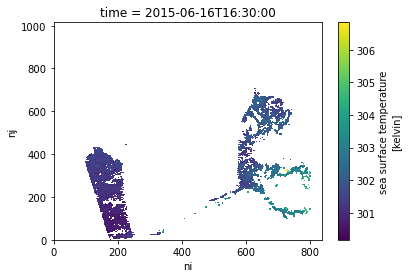

In [67]:

with xr.open_dataset(subsets_day.iloc[0].path) as ds:

    # Create a mask for pixels that are 
    quality_mask = ds.quality_level[0]==5

    # Fill pixels where ###### with np.nan:
    masked_ds = ds.where(quality_mask)

    # Plot the resulting array of sea surface temperature:
    masked_ds.sea_surface_temperature[0].plot()


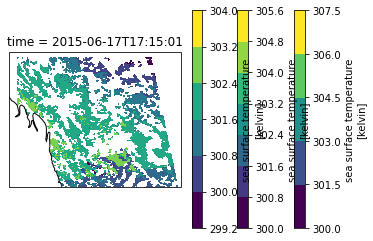

In [83]:
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())

for swath in subsets_day.iloc:
    with xr.open_dataset(swath.path) as ds:

        # Create a mask for pixels that are 
        quality_mask = ds.quality_level[0]==5

        # Fill pixels where ###### with np.nan:
        masked_ds = ds.where(quality_mask)

        # Plot the resulting array of sea surface temperature:
        masked_ds.sea_surface_temperature[0].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar = True)
ax.coastlines()

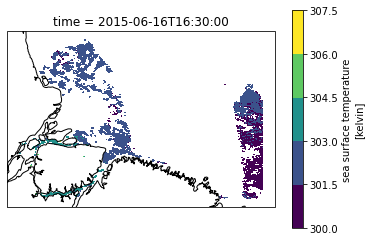

In [96]:
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
with xr.open_dataset(subsets_day.iloc[0].path) as ds:

    # Create a mask for pixels that are 
    quality_mask = ds.quality_level[0]==5

    # Fill pixels where ###### with np.nan:
    masked_ds = ds.where(quality_mask)

    # Plot the resulting array of sea surface temperature:
    masked_ds.sea_surface_temperature[0].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar = True)
ax.coastlines()

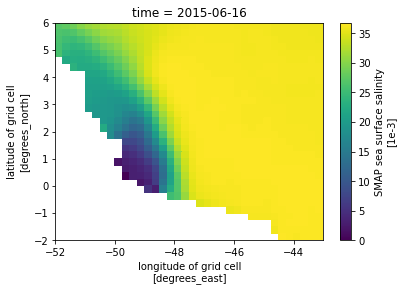

In [107]:
#SMAP
lat_bnds, lon_bnds = [6, -2], [-52, -43] #switched lat directions from GRACE, and longitude has positives and negatives
ds_SMAP_subset = ds_SMAP.sel(latitude=slice(*lat_bnds), longitude=slice(*lon_bnds))
#ds_SMAP_subset

#plot SMAP subset
ds_SMAP_subset.smap_sss[2,:,:].plot() #at time '2', indicating June 2015

plt.show()

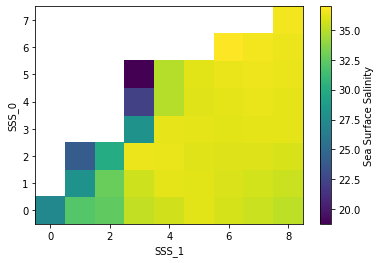

In [22]:
# #Aquarius
# lat_bnds, lon_bnds = [84, 92], [128, 137] #See how commented out plot is distorted, only positive numbers
# ds_Aq_subset = ds_Aq.sel(SSS_0=slice(*lat_bnds), SSS_1=slice(*lon_bnds))
# #ds_Aq_subset

# #plot Aquarius subset
# #this map is inverted compared to SMAP, but still caputuring the same area
# ds_Aq_subset.SSS[10,:,:].plot() #at time '10' indicating June 2012
# #ds_Aq.SSS[10,:,:].plot() #whole world map view to see the inversion of the data

# plt.show()

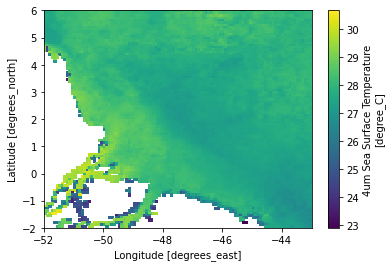

In [23]:
#MODIS SST
lat_bnds, lon_bnds = [6, -2], [-52, -43] #like SMAP
ds_MODIS_subset = ds_MODIS.sel(lat=slice(*lat_bnds), lon=slice(*lon_bnds))
#ds_MODIS_subset

#plot MODIS subset
ds_MODIS_subset.sst4[2,:,:].plot() #at time '2', indicating Oct 2011

plt.show()

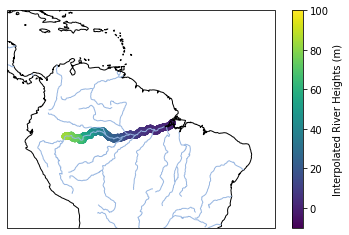

In [101]:
#Plotting the river distances and associated heights on the map at time t=9069 (March 16, 2018)
#Change the extent to capture the data of the netCDF file
extent = [-85, -30, -20, 20]

#Add basemap
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent(extent)
ax.add_feature(cartopy.feature.RIVERS)

plt.scatter(ds_MEaSUREs.lon, ds_MEaSUREs.lat, lw=1, c=ds_MEaSUREs.height[:,9069])
plt.colorbar(label='Interpolated River Heights (m)')
plt.clim(-10,100)

plt.show()

In [25]:
# ########################### Defining needed functions ###########################

# #create map for specific timestep function
# def setup_map(ax, map, ds_subset, x, y, var, t, cmap, levels, title, extent):
#     map.set_title(title, fontsize=14)
#     map.coastlines()
#     map.set_extent(extent)
#     map.add_feature(cartopy.feature.RIVERS)
#     variable_desired = var[t,:,:]
#     title = str(pd.to_datetime(ds_subset.time[t].values))
#     cont = map.contourf(x, y, variable_desired, cmap=cmap, levels=levels, zorder=1)
#     return cont

# #create animation function for all timesteps, outlines what needs to change
# def animate_ts(framenumber, ax, map, ds_subset, x, y, var, t, cmap, levels, title, extent):
#     ax.clear()
#     # change to next timestep
#     t = t + framenumber
#     title = str(pd.to_datetime(ds_subset.time[t].values))
#     cont = setup_map(ax, map, ds_subset, x, y, var, t, cmap, levels, title, extent) 
#     return cont

# ##################################################################################

<ipython-input-26-6dc8f62d699b>:19: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  fig.colorbar(cont, cmap=cmap, boundaries=levels, ticks=levels,
<ipython-input-26-6dc8f62d699b>:19: MatplotlibDeprecationWarning: The 'boundaries' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  fig.colorbar(cont, cmap=cmap, boundaries=levels, ticks=levels,


AttributeError: 'NoneType' object has no attribute 'dpi_scale_trans'

C:\Users\celiaou\Anaconda3\envs\swotea\lib\site-packages\cartopy\io\__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
C:\Users\celiaou\Anaconda3\envs\swotea\lib\site-packages\cartopy\io\__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_rivers_lake_centerlines.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


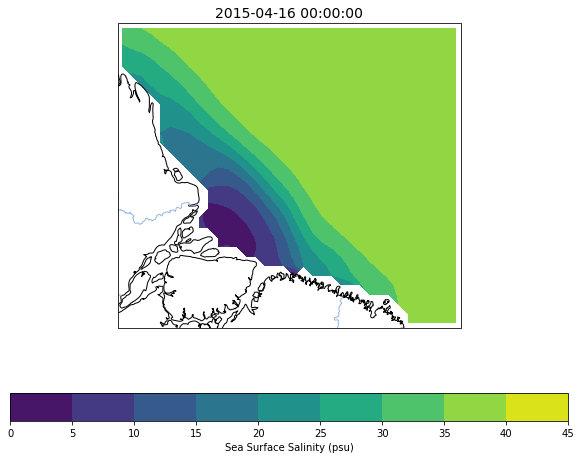

In [26]:
# #A new figure window
# fig = plt.figure(figsize=[10,8]) 
# ax = fig.add_subplot(1, 1, 1)  # specify (nrows, ncols, axnum)
# map = plt.axes(projection=ccrs.PlateCarree())

# #Necessary Variables for functions
# extent = [-52, -43, -2, 6]                                           #lat/lon extents of map
# x,y = np.meshgrid(ds_SMAP_subset.longitude, ds_SMAP_subset.latitude) #x, y lat/lon values for functions                                
# levels = np.linspace(0., 45., 10)                                    #number of levels for color differentiation
# cmap='viridis'                                                       #color scheme
# t=0                                                                  #time to start with
# var = ds_SMAP_subset.smap_sss                                        #variable we will be subsetting from the GRACE-FO data
# title = str(pd.to_datetime(ds_SMAP_subset.time[t].values))           #Time of specific time step

# #Set up first time step
# cont = setup_map(ax, map, ds_SMAP_subset, x, y, var, t, cmap, levels, title, extent) 

# #Make a color bar
# fig.colorbar(cont, cmap=cmap, boundaries=levels, ticks=levels, 
#              orientation='horizontal', label='Sea Surface Salinity (psu)')

# #Create animation for the 2019 year (change the frame range for different time periods)
# ani = animation.FuncAnimation(fig, animate_ts, frames=range(45,57),
#             fargs=(ax, map, ds_SMAP_subset, x, y, var, t, cmap, levels, title, extent),  interval=400)

# #Will need to install 'ffmpeg' in the cmd prompt to save the .mpg (ie. conda install -c conda-forge ffmpeg)
# ani.save("SMAP_animation.mp4", writer=animation.FFMpegWriter())

# HTML(ani.to_html5_video())

In [27]:
# #Aquarius
# time_Aq = np.arange('2011-08', '2015-07', dtype='datetime64[M]')
# sss_Aq_mean =[]
# for t in np.arange(len(ds_Aq_subset.time)):
#     sss_Aq_mean.append(np.nanmean(ds_Aq_subset.SSS[t,:,:].values))

# #sss_Aq_mean  

In [108]:
#SMAP
time_smap = np.arange('2015-04', '2020-01', dtype='datetime64[M]')
sss_smap_mean = []
for t in np.arange(len(ds_SMAP_subset.time)):
    sss_smap_mean.append(np.nanmean(ds_SMAP_subset.smap_sss[t,:,:].values))
    
#sss_smap_mean

In [29]:
# #MODIS
# time_MODIS = np.arange('2011-08', '2019-12', dtype='datetime64[M]')
# sst_MODIS_mean = []
# for t in np.arange(len(ds_MODIS_subset.time)):
#     sst_MODIS_mean.append(np.nanmean(ds_MODIS_subset.sst4[t,:,:].values))
    
# #sst_MODIS_mean

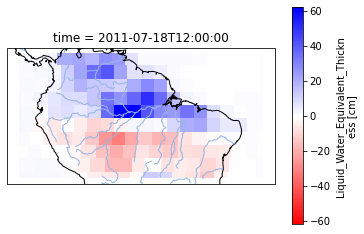

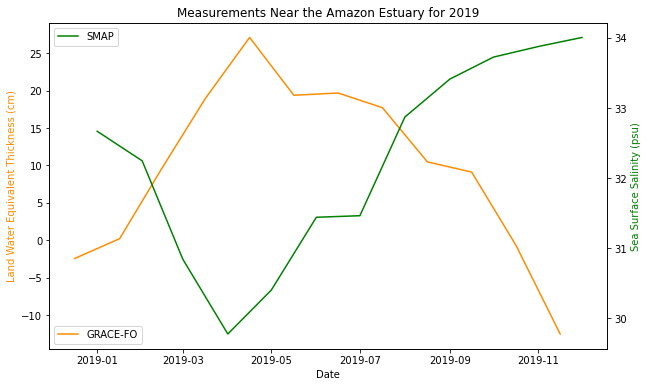

In [109]:
#GRACE-FO (different bounds than others because GRACE is over land)
lat_bnds, lon_bnds = [-18, 10], [275, 330] #degrees east for longitude
ds_GRACE_subset = ds_GRACE.sel(lat=slice(*lat_bnds), lon=slice(*lon_bnds))
ds_GRACE_subset

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.RIVERS)
ds_GRACE_subset.lwe_thickness[106,:,:].plot(cmap = 'bwr_r') #July 2011
plt.show()

#plot SSS and LWE thickness

fig, ax1 = plt.subplots(figsize=[10,6])
#plot LWE thickness
ax1.plot(ds_GRACE_subset.time[167:179], ds_GRACE_subset.lwe_thickness[167:179,34,69], color = 'darkorange')

#plot SSS on secondary axis
ax2 = ax1.twinx()
ax2.plot(time_smap[45:], sss_smap_mean[45:], 'g-')

ax1.set_xlabel('Date')
ax2.set_ylabel('Sea Surface Salinity (psu)', color='g')
ax1.set_ylabel('Land Water Equivalent Thickness (cm)', color='darkorange')
ax2.legend(['SMAP'], loc='upper left')
ax1.legend(['GRACE-FO'], loc='lower left')
plt.title('Measurements Near the Amazon Estuary for 2019')

plt.show()

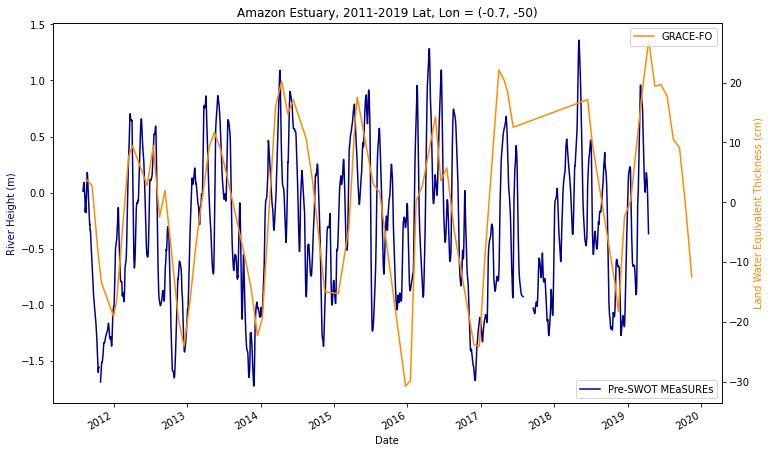

In [110]:
#plot variables associated with river

fig, ax1 = plt.subplots(figsize=[12,7])
#plot river height
ds_MEaSUREs.height[16,6689:9469].plot(color='darkblue')

#plot LWE thickness on secondary axis
ax2 = ax1.twinx()
ax2.plot(ds_GRACE_subset.time[107:179], ds_GRACE_subset.lwe_thickness[107:179,34,69], color = 'darkorange')

ax1.set_xlabel('Date')
ax2.set_ylabel('Land Water Equivalent Thickness (cm)', color='darkorange')
ax1.set_ylabel('River Height (m)', color='darkblue')
ax2.legend(['GRACE-FO'], loc='upper right')
ax1.legend(['Pre-SWOT MEaSUREs'], loc='lower right')

plt.title('Amazon Estuary, 2011-2019 Lat, Lon = (-0.7, -50)')

plt.show()